In [21]:
#Importing various modules important for our project

In [17]:
import cv2
import time
import random
import numpy as np
import imutils
%matplotlib inline
import seaborn as sns
import tensorflow as tf
from os import listdir
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Add, Activation, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense, Dropout


In [8]:
# importing our dataset we will put that dataset in variable image_directory

In [9]:
# About dataset:The dataset contains 2 folders: yes and no which contains 253 Brain MRI Images.
# The folder yes contains 155 Brain MRI Images that are tumorous and the folder no contains 98 Brain MRI Images that are non-tumorous.

In [11]:
image_directory = 'Dataset/'

In [11]:
# Data Preparation & Preprocessing

In [18]:
def crop_brain_contour(image, plot=False):
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    if cnts:
        c = max(cnts, key=cv2.contourArea)

        # Find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])
        
        # Crop new image out of the original image using the four extreme points (left, right, top, bottom)
        new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            
        
        if plot:
            plt.figure()
            plt.subplot(1, 2, 1)
            plt.imshow(image)
            plt.title('Original Image')
            
            plt.subplot(1, 2, 2)
            plt.imshow(new_image)
            plt.title('Cropped Image')
            
            plt.show()
        
        return new_image
    else:
        print("No contours found in the image.")
        return None

In [54]:
# let's see an example

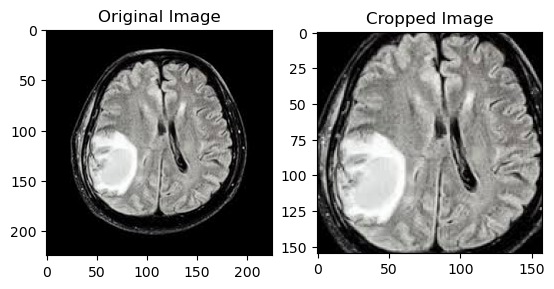

In [4]:
ex_img = cv2.imread('images.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

In [56]:
#Loading, cropping, resizing, normalization the image is done by the below function

In [19]:
def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them. 
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '\\' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [58]:
#now will laod our augmented data that contains not only augmented data but also the original images

In [20]:
augmented_path = 'augmented data/'

# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = augmented_path + 'yes' 
augmented_no = augmented_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 2065
X shape is: (2065, 240, 240, 3)
y shape is: (2065, 1)


In [60]:
#we will plot some images to see how it looks

In [7]:
def plot_sample_images(X, y, n=50):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

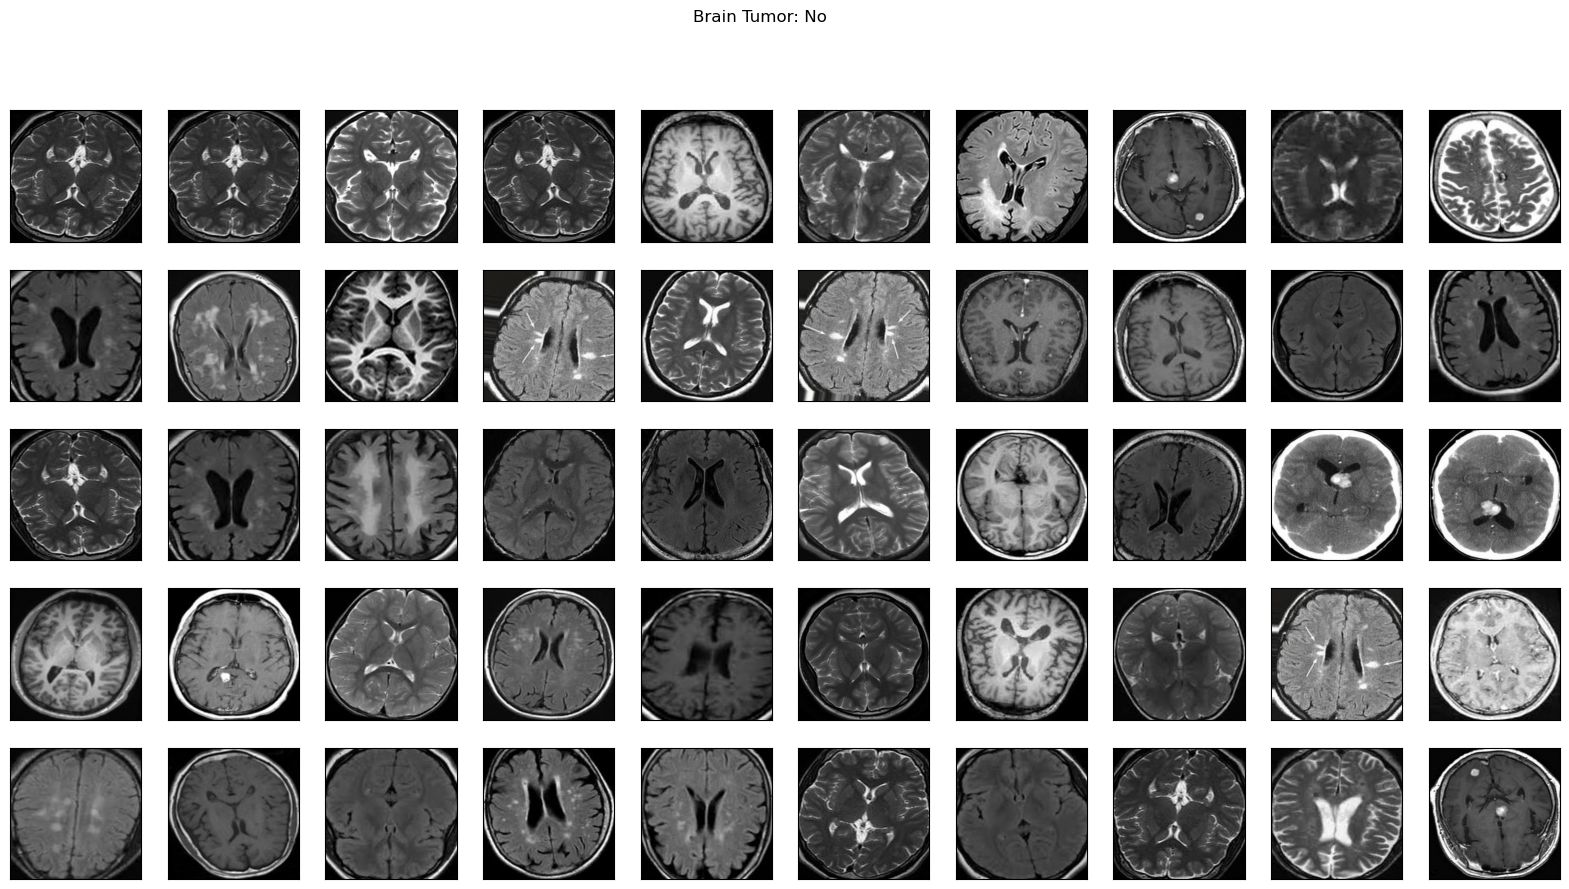

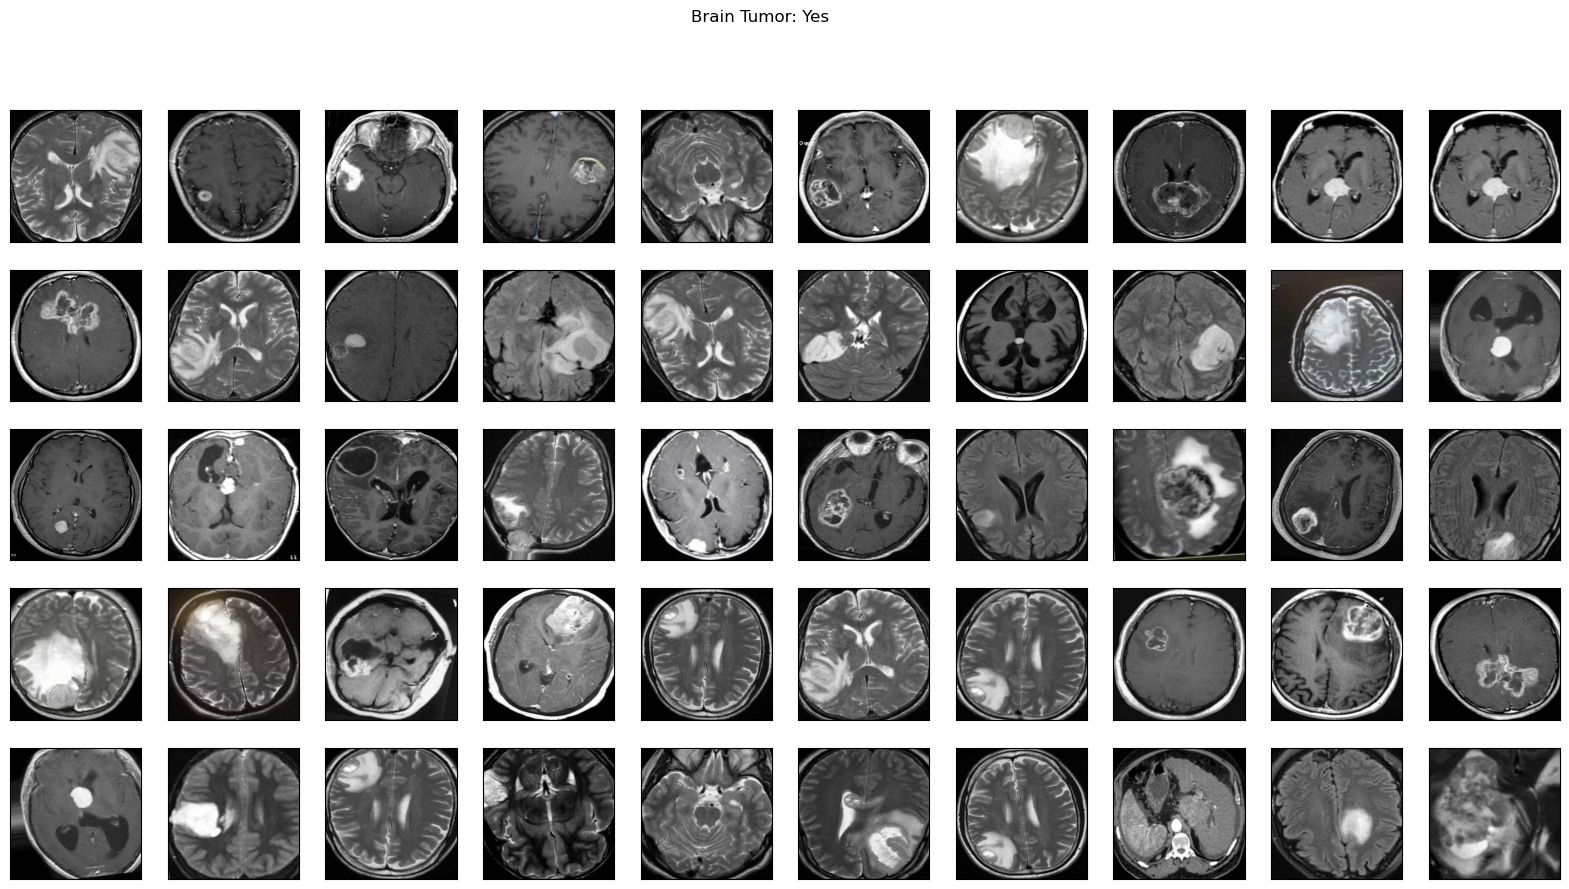

In [11]:
plot_sample_images(X, y)

In [56]:
#Split X and y into training, validation (development) and validation sets.

In [21]:
def split_data(X, y, test_size=0.2):
    """
    Splits data into training, development, and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
        test_size: Proportion of the dataset to include in the test split.
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """
    # Splitting data into training and test+validation sets
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    # Further splitting test+validation into separate test and validation sets
    test_val_size = 0.5 * (1 - test_size)  # Adjusting size relative to remaining data after test split
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_val_size, random_state=42)
    
    return X_train_val, y_train_val, X_val, y_val, X_test, y_test

# Split the data
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [63]:
#let's see now how our dataset will look after splitting

In [8]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1445
number of development examples = 403
number of test examples = 217
X_train shape: (1445, 240, 240, 3)
Y_train shape: (1445, 1)
X_val (dev) shape: (403, 240, 240, 3)
Y_val (dev) shape: (403, 1)
X_test shape: (217, 240, 240, 3)
Y_test shape: (217, 1)


In [64]:
#Building the model

# We will try first architecture with simplified version of LeNet-5

In [12]:
def create_lenet(input_shape):
    model = Sequential([
        Conv2D(6, (5, 5), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(16, (5, 5), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(120, activation='relu'),
        Dense(84, activation='relu'),
        Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])
    return model

model = create_lenet((240, 240, 3))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=24, batch_size=80, validation_data=(X_val, y_val))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)

Epoch 1/24
19/19 [==============================] - 17s 729ms/step - loss: 1.3172 - accuracy: 0.4962 - val_loss: 0.6896 - val_accuracy: 0.5533
Epoch 2/24
19/19 [==============================] - 11s 554ms/step - loss: 0.6660 - accuracy: 0.6325 - val_loss: 0.5861 - val_accuracy: 0.7097
Epoch 3/24
19/19 [==============================] - 11s 559ms/step - loss: 0.5079 - accuracy: 0.7536 - val_loss: 0.4493 - val_accuracy: 0.7792
Epoch 4/24
19/19 [==============================] - 20s 1s/step - loss: 0.3649 - accuracy: 0.8401 - val_loss: 0.4167 - val_accuracy: 0.8337
Epoch 5/24
19/19 [==============================] - 11s 583ms/step - loss: 0.2398 - accuracy: 0.9100 - val_loss: 0.4639 - val_accuracy: 0.8288
Epoch 6/24
19/19 [==============================] - 11s 596ms/step - loss: 0.1617 - accuracy: 0.9391 - val_loss: 0.4414 - val_accuracy: 0.8437
Epoch 7/24
19/19 [==============================] - 10s 547ms/step - loss: 0.0864 - accuracy: 0.9772 - val_loss: 0.4712 - val_accuracy: 0.8412
Ep

In [14]:
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.8525345325469971


In [ ]:
#saving model

In [16]:
model.save("my_lanet_model.keras")

In [ ]:
#loading model

In [17]:
loaded1_model = load_model("my_lanet_model.keras")

In [15]:
from sklearn.metrics import f1_score

# Assuming you have a trained model and a test set (X_test, y_test)

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)  # Convert probabilities to binary predictions (0 or 1)

# Calculate the F1 score
f1 = f1_score(y_test, y_pred)

print("F1 Score:", f1)


7/7 [==============================] - 1s 62ms/step
F1 Score: 0.8699186991869918


In [ ]:
#loading and testing the accuracy with an image

In [18]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load an MRI image (example)
img_path = "DataSet/yes/y1010.jpg"  # Replace with the path to your MRI image
img = image.load_img(img_path, target_size=(240, 240))  # Assuming your model expects input shape of (240, 240)

# Preprocess the image
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.  # Normalize pixel values

# Make prediction
prediction = loaded1_model.predict(img_array)

# Interpret prediction
if prediction[0][0] > 0.5:
    print("Tumor detected!")
else:
    print("No tumor detected.")

1/1 [==============================] - 0s 186ms/step
Tumor detected!


In [33]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 236, 236, 6)       456       
                                                                 
 max_pooling2d (MaxPooling2  (None, 118, 118, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 114, 114, 16)      2416      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 57, 57, 16)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 51984)             0         
                                                                 
 dense (Dense)               (None, 120)              

In [ ]:
#lets plot confusion matrix for visualization of our model

7/7 [==============================] - 1s 60ms/step


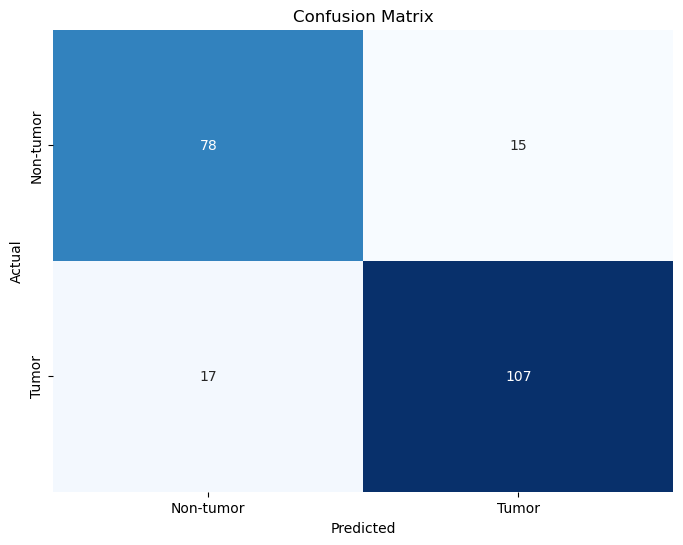

In [19]:
Y_pred = model.predict(X_test)
Y_pred_classes = (Y_pred > 0.5).astype("int32")

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, Y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=['Non-tumor', 'Tumor'], yticklabels=['Non-tumor', 'Tumor'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
#lets plot Receiver Operating Characteristic Curve (ROC) 

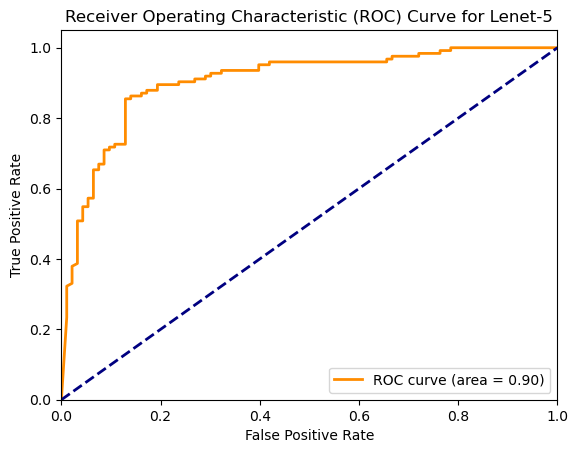

In [20]:
fpr, tpr, thresholds = roc_curve(y_test, Y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Lenet-5')
plt.legend(loc="lower right")
plt.show()

In [35]:
#Lets plot Precison Recall curve

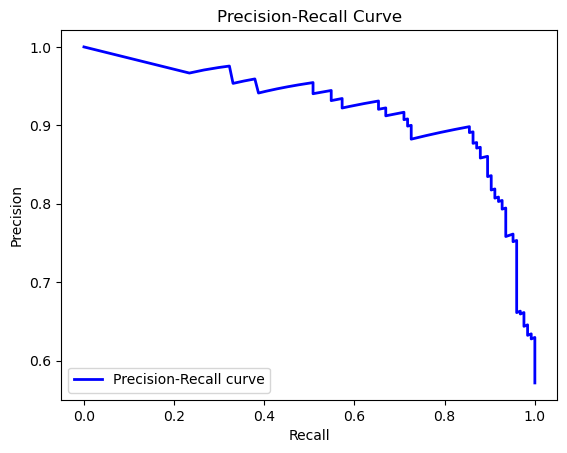

In [21]:
precision, recall, _ = precision_recall_curve(y_test, Y_pred)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

In [39]:
#Now lets Plot Loss and Accuracy

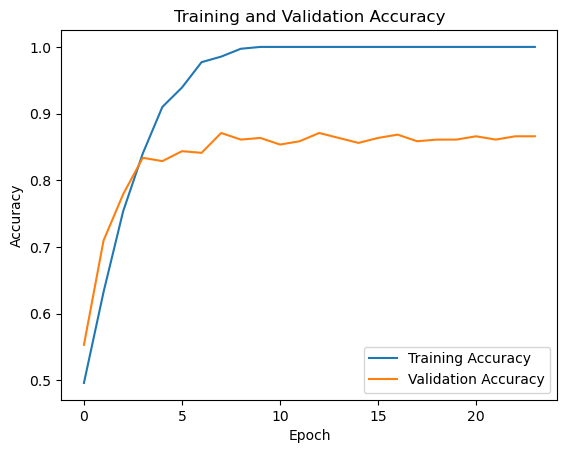

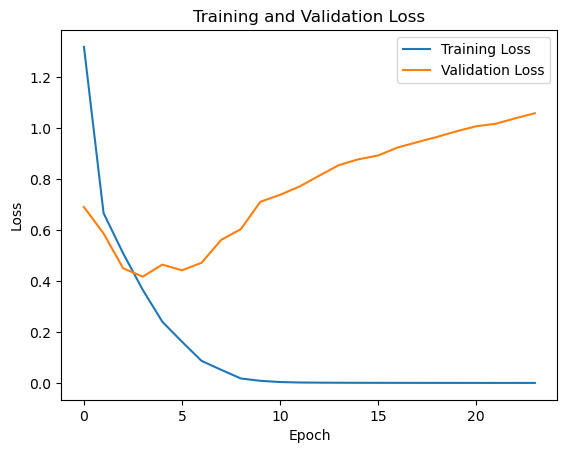

In [22]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# lets try a different CNN model from scratch

In [23]:
def build_model(input_shape):
    model = Sequential([
        Conv2D(32, (7, 7), strides=(1, 1), padding='same', input_shape=input_shape, name='conv0'),
        BatchNormalization(axis=3, name='bn0'),
        Activation('relu'),
        MaxPooling2D((4, 4), name='max_pool0'),
        MaxPooling2D((4, 4), name='max_pool1'),
        Flatten(),
        Dense(1, activation='sigmoid', name='fc')       
        
    ])
    return model

model = build_model((240,240,3))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=24, batch_size=100, validation_data=(X_val, y_val))

test_loss, test_accuracy = model.evaluate(X_test, y_test)

Epoch 1/24
15/15 [==============================] - 58s 3s/step - loss: 0.9875 - accuracy: 0.5647 - val_loss: 0.6740 - val_accuracy: 0.6328
Epoch 2/24
15/15 [==============================] - 71s 5s/step - loss: 0.6652 - accuracy: 0.6491 - val_loss: 0.6571 - val_accuracy: 0.5856
Epoch 3/24
15/15 [==============================] - 52s 4s/step - loss: 0.4803 - accuracy: 0.7723 - val_loss: 0.6466 - val_accuracy: 0.6725
Epoch 4/24
15/15 [==============================] - 49s 3s/step - loss: 0.4305 - accuracy: 0.8076 - val_loss: 0.6370 - val_accuracy: 0.6328
Epoch 5/24
15/15 [==============================] - 57s 4s/step - loss: 0.3855 - accuracy: 0.8304 - val_loss: 0.6211 - val_accuracy: 0.6873
Epoch 6/24
15/15 [==============================] - 59s 4s/step - loss: 0.3598 - accuracy: 0.8561 - val_loss: 0.6139 - val_accuracy: 0.6650
Epoch 7/24
15/15 [==============================] - 58s 4s/step - loss: 0.3405 - accuracy: 0.8699 - val_loss: 0.6149 - val_accuracy: 0.6079
Epoch 8/24
15/15 [==

In [24]:
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.861751139163971


In [69]:
from sklearn.metrics import f1_score

# Assuming you have a trained model and a test set (X_test, y_test)

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)  # Convert probabilities to binary predictions (0 or 1)

# Calculate the F1 score
f1 = f1_score(y_test, y_pred)

print("F1 Score:", f1)


7/7 [==============================] - 1s 98ms/step
F1 Score: 0.8934426229508197


In [51]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv0 (Conv2D)              (None, 240, 240, 32)      4736      
                                                                 
 bn0 (BatchNormalization)    (None, 240, 240, 32)      128       
                                                                 
 activation_1 (Activation)   (None, 240, 240, 32)      0         
                                                                 
 max_pool0 (MaxPooling2D)    (None, 60, 60, 32)        0         
                                                                 
 max_pool1 (MaxPooling2D)    (None, 15, 15, 32)        0         
                                                                 
 flatten_2 (Flatten)         (None, 7200)              0         
                                                                 
 fc (Dense)                  (None, 1)                

In [25]:
model.save("my_custom_model.keras")

In [26]:
loaded2_model = load_model("my_custom_model.keras")

In [27]:
from sklearn.metrics import f1_score

# Assuming you have a trained model and a test set (X_test, y_test)

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)  # Convert probabilities to binary predictions (0 or 1)

# Calculate the F1 score
f1 = f1_score(y_test, y_pred)

print("F1 Score:", f1)


7/7 [==============================] - 2s 205ms/step
F1 Score: 0.8728813559322034


In [28]:
# Load an MRI image (example)
img_path = "DataSet/yes/y1010.jpg"  # Replace with the path to your MRI image
img = image.load_img(img_path, target_size=(240, 240))  # Assuming your model expects input shape of (240, 240)

# Preprocess the image
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.  # Normalize pixel values

# Make prediction
prediction = loaded2_model.predict(img_array)

# Interpret prediction
if prediction[0][0] > 0.5:
    print("Tumor detected!")
else:
    print("No tumor detected.")

1/1 [==============================] - 0s 121ms/step
No tumor detected.


7/7 [==============================] - 1s 201ms/step


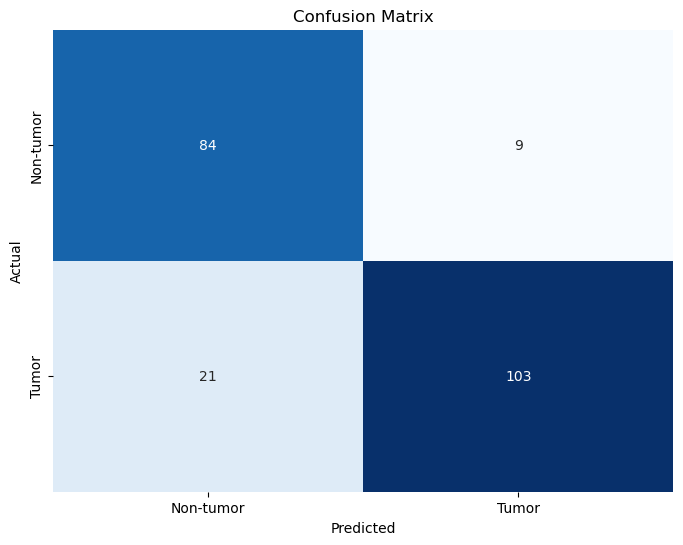

In [29]:
Y_pred = model.predict(X_test)
Y_pred_classes = (Y_pred > 0.5).astype("int32")  # Assuming threshold of 0.5 for binary classification

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, Y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=['Non-tumor', 'Tumor'], yticklabels=['Non-tumor', 'Tumor'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

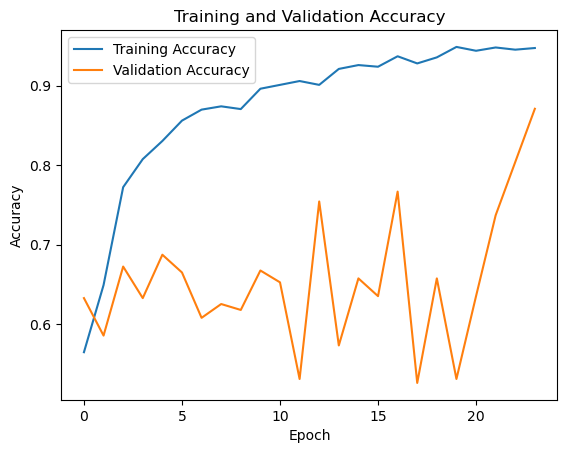

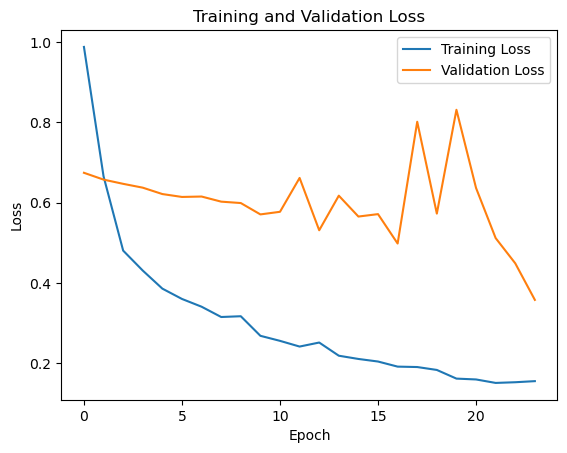

In [30]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

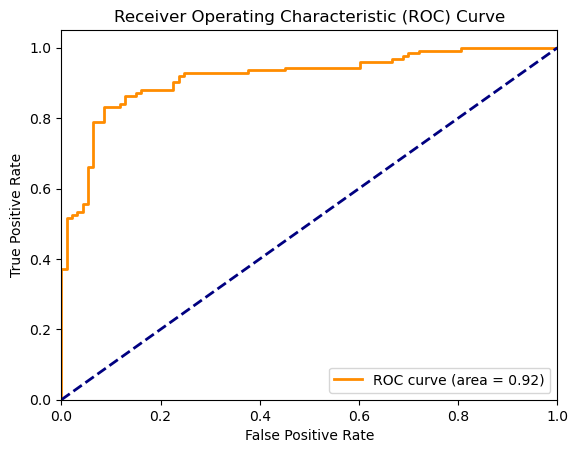

In [31]:
fpr, tpr, thresholds = roc_curve(y_test, Y_pred)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


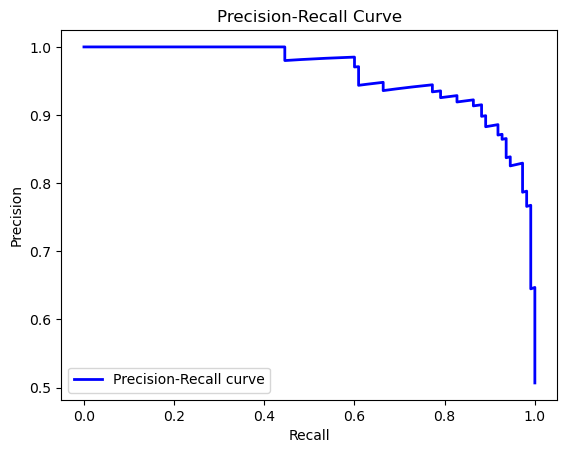

In [61]:
precision, recall, _ = precision_recall_curve(y_test, Y_pred)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()


# lets try a different architecture resnet

In [22]:
import tensorflow as tf
import warnings
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

def resnet_block(input_tensor, filters, kernel_size=(3, 3), strides=(1, 1), activation='relu'):
    x = Conv2D(filters, kernel_size, strides=strides, padding='same')(input_tensor)
    x = BatchNormalization(axis=3)(x)
    x = Activation(activation)(x)
    
    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization(axis=3)(x)
    
    # Add shortcut connection
    shortcut = Conv2D(filters, (1, 1), strides=strides, padding='same')(input_tensor)
    shortcut = BatchNormalization(axis=3)(shortcut)
    
    x = Add()([x, shortcut])
    x = Activation(activation)(x)
    return x

def create_resnet_model(input_shape):
    inputs = Input(shape=input_shape)
    
    # Initial convolution and pooling
    x = Conv2D(32, (7, 7), strides=(1, 1), padding='same')(inputs)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)
    
    # Stack of residual blocks
    x = resnet_block(x, filters=32)
    x = MaxPooling2D((4, 4))(x)
    x = resnet_block(x, filters=32)
    x = MaxPooling2D((4, 4))(x)
    
    x = Flatten()(x)
    x = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs, x)
    return model

def train_and_evaluate_resnet(X_train, y_train, X_val, y_val, X_test, y_test, input_shape=(240, 240, 3), epochs=24, batch_size=100):
    model = create_resnet_model(input_shape)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))
    
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    
    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_accuracy}")
    
    return model, history, test_loss, test_accuracy

# X_train, y_train, X_val, y_val, X_test, and y_test are predefined and properly formatted

input_shape = (240, 240, 3)
model, history, test_loss, test_accuracy = train_and_evaluate_resnet(X_train, y_train, X_val, y_val, X_test, y_test, input_shape=input_shape)


MemoryError: Unable to allocate 1.86 GiB for an array with shape (1445, 240, 240, 3) and data type float64

In [15]:
import pickle

In [16]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 240, 240, 3)]        0         []                            
                                                                                                  
 conv2d_7 (Conv2D)           (None, 240, 240, 32)         4736      ['input_2[0][0]']             
                                                                                                  
 batch_normalization_7 (Bat  (None, 240, 240, 32)         128       ['conv2d_7[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 activation_5 (Activation)   (None, 240, 240, 32)         0         ['batch_normalization_7[

In [72]:
model.save("my_resnet_model.keras")

In [74]:
loaded3_model = load_model("my_resnet_model.keras")

In [74]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load an MRI image (example)
img_path = "DataSet/yes/y1010.jpg"  # Replace with the path to your MRI image
img = image.load_img(img_path, target_size=(240, 240))  # Assuming your model expects input shape of (240, 240)

# Preprocess the image
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.  # Normalize pixel values

# Make prediction
prediction = loaded3_model.predict(img_array)

# Interpret prediction
if prediction[0][0] > 0.5:
    print("Tumor detected!")
else:
    print("No tumor detected.")


1/1 [==============================] - 0s 97ms/step
Tumor detected!


7/7 [==============================] - 1s 200ms/step


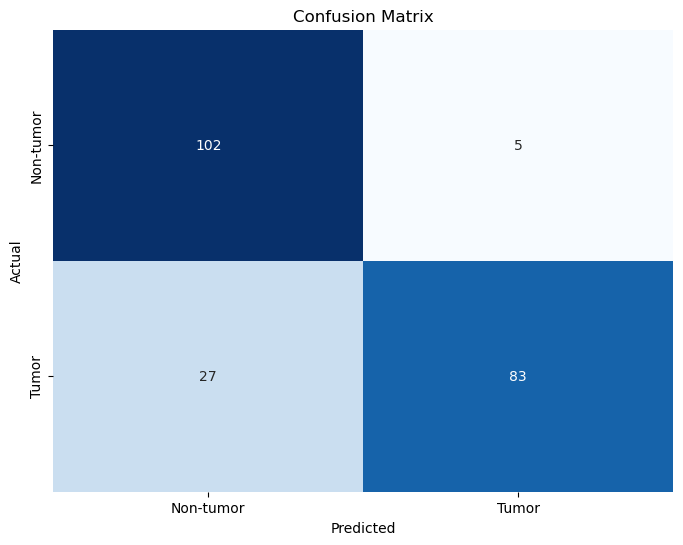

In [75]:
Y_pred = model.predict(X_test)
Y_pred_classes = (Y_pred > 0.5).astype("int32")  # Assuming threshold of 0.5 for binary classification

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, Y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=['Non-tumor', 'Tumor'], yticklabels=['Non-tumor', 'Tumor'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

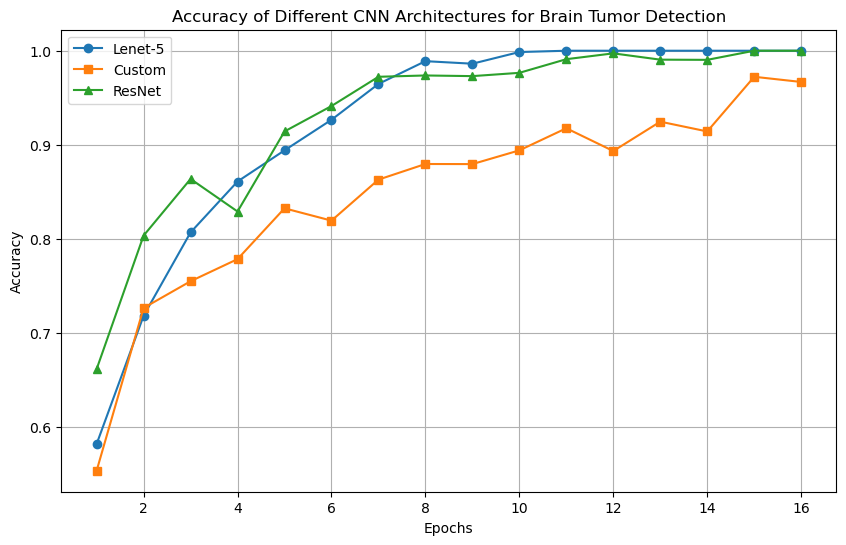

In [24]:
import matplotlib.pyplot as plt

# Example accuracy data for each architecture across epochs
# Replace these lists with your actual accuracy data
epochs = range(1, 17)  # Assuming you have data for 20 epochs
accuracy_arch1 = [0.5820,0.7183,0.8069,0.8610,0.8941,0.9266,0.9647,0.9889,0.9862,0.9986,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000]
accuracy_arch2 = [0.5536,0.7266,0.7550,0.7785,0.8325,0.8194,0.8630,0.8796,0.8795,0.8941,0.9176,0.8934,0.9246,0.9142,0.9723,0.9668]
accuracy_arch3 = [0.6616,0.8035,0.8637,0.8291,0.9142,0.9412,0.9723,0.9737,0.9730,0.9765,0.9910,0.9972,0.9905,0.9903,1.0000,1.0000]

plt.figure(figsize=(10, 6))

# Plotting accuracies for each architecture
plt.plot(epochs, accuracy_arch1, label='Lenet-5', marker='o')
plt.plot(epochs, accuracy_arch2, label='Custom', marker='s')
plt.plot(epochs, accuracy_arch3, label='ResNet', marker='^')

# Adding titles and labels
plt.title('Accuracy of Different CNN Architectures for Brain Tumor Detection')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()


In [43]:
from sklearn.metrics import f1_score

# Assuming you have a trained model and a test set (X_test, y_test)

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)  # Convert probabilities to binary predictions (0 or 1)

# Calculate the F1 score
f1 = f1_score(y_test, y_pred)

print("F1 Score:", f1)


7/7 [==============================] - 9s 1s/step
F1 Score: 0.7586206896551725
